<a href="https://colab.research.google.com/github/bharshal/car_damage_detector/blob/master/final_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# for augmentations
!pip install albumentations==0.4.3

# for pretrained segmentation models fo PyTorch
!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach==0.0.2

# Catalyst itself
!pip install -U catalyst

# for tensorboard
!pip install tensorflow


In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import numpy as np
import segmentation_models_pytorch as smp
import cv2
import albumentations as albu

In [13]:
damage_model = torch.load('/content/drive/My Drive/task_artivartic/weights/damage_seg.pth')
part_model = torch.load('/content/drive/My Drive/task_artivartic/weights/part_seg.pth')

In [14]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [17]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=100, min_width=100, always_apply=True, border_mode=0),
        albu.RandomCrop(height=900, width=1000, always_apply=False),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn, image_size=224):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Resize(image_size, image_size, p=1),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [34]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 8))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "




Damage is in front_bumper of car


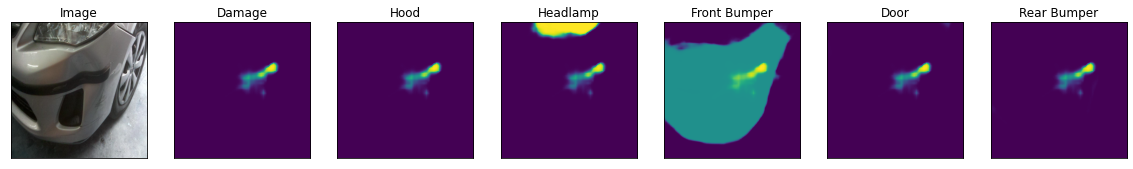



Damage is in door of car


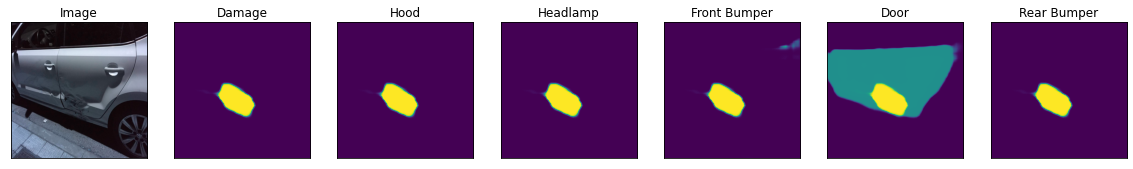



Damage is in door of car


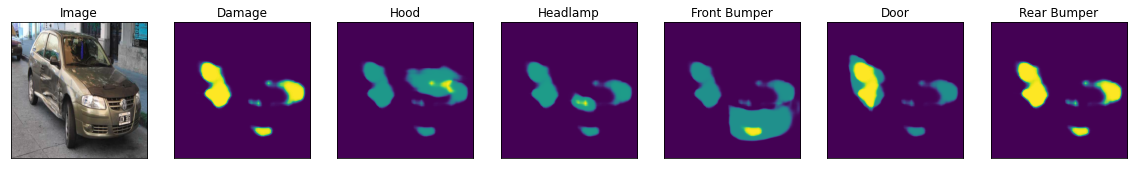



Damage is in front_bumper of car


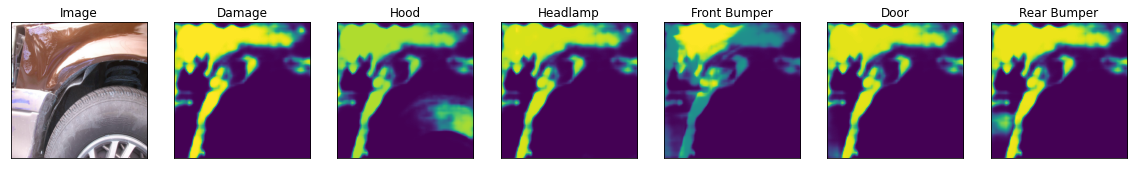



Damage is in door of car


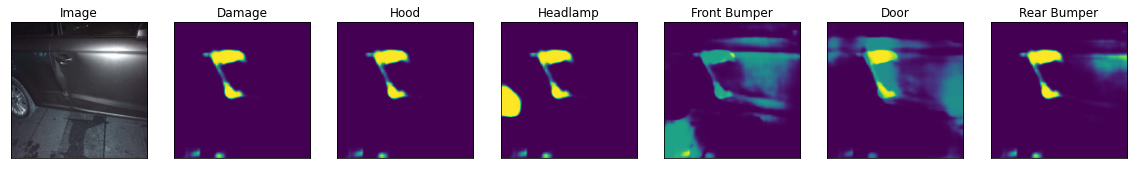



Damage is in front_bumper of car


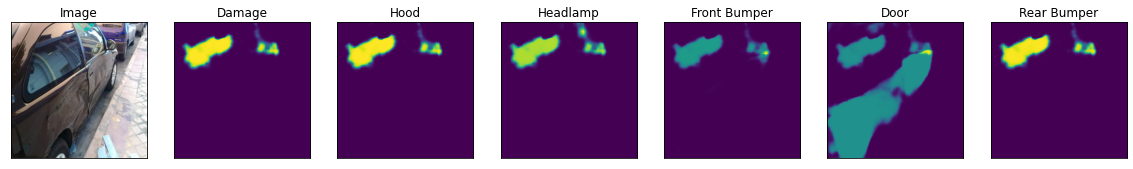



Damage is in front_bumper of car


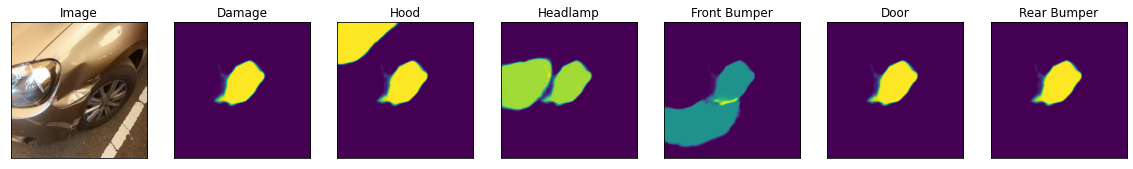



Damage is in door of car


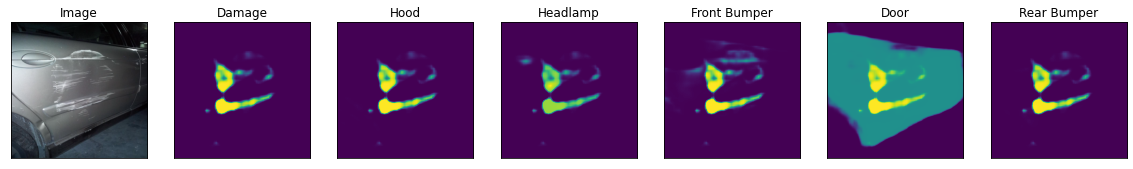

In [56]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import matplotlib.pyplot as plt

image_size = 224
_transform = [
      albu.Resize(image_size, image_size, p=1),
      albu.Lambda(image=preprocessing_fn),
      albu.Lambda(image=to_tensor),
  ]
trans = albu.Compose(_transform)
classes = ['hood', 'headlamp', 'front_bumper', 'door', 'rear_bumper']

for file_name in os.listdir('/content/drive/My Drive/task_artivartic/dataset/test'):
  _frame = cv2.imread('/content/drive/My Drive/task_artivartic/dataset/test/'+str(file_name))
  
  frame = trans(image=_frame)
  
  abc  = torch.unsqueeze(torch.Tensor(frame["image"]), dim = 0)

  damage = damage_model(abc.cuda())
  damage = damage.squeeze().cpu().detach().numpy()
  part = part_model(abc.cuda())
  part = part.squeeze().cpu().detach().numpy()
  part = np.transpose(part, (1, 2, 0))


  hood = damage+part[:,:,0]
  headlamp = damage+part[:,:,1]
  front_bumper = damage+part[:,:,2]
  door = damage+part[:,:,3]
  rear_bumper = damage+part[:,:,4]

  iou = []
  for i in range(5):
    overlap = damage*part[:,:,i]
    union = damage+part[:,:,i]
    IOU = overlap.sum()/float(union.sum())
    iou.append(IOU)
    #print("{:.5f}".format(IOU*100))
  #index = iou.index(max(iou))

  print("\n\nDamage is in {} of car".format(classes[iou.index(max(iou))]))

  visualize(image=_frame, damage=damage.squeeze(), hood=hood.squeeze(),headlamp=headlamp.squeeze(),front_bumper=front_bumper.squeeze(),door=door.squeeze(),rear_bumper=rear_bumper.squeeze()
  )
